Importing Useful Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
!cp /content/drive/'My Drive'/'Colab Notebooks'/StanceDataset.zip .
!unzip -q -o StanceDataset.zip -d data
!rm StanceDataset.zip
!unzip -uq "/content/drive/My Drive/Colab Notebooks/StanceDataset.zip" -d "/content/drive/My Drive/Colab Notebooks/data"

In [5]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
import numpy as np
import pandas as pd

import tensorflow_datasets as tfds
import pathlib
import shutil
import tempfile

from  IPython import display
from matplotlib import pyplot as plt

##Data Extraction and Exploration


In [95]:
stance_df = pd.read_csv("../content/drive/My Drive/Colab Notebooks/data/StanceDataset/train.csv", index_col = None, header = 0, engine = 'python')
stance_df.head()

,Tweet,Target,Stance,Opinion Towards,Sentiment
0,"@tedcruz And, #HandOverTheServer she wiped cle...",Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
1,Hillary is our best choice if we truly want to...,Hillary Clinton,FAVOR,1. The tweet explicitly expresses opinion abo...,pos
2,@TheView I think our country is ready for a fe...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
3,I just gave an unhealthy amount of my hard-ear...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
4,@PortiaABoulger Thank you for adding me to you...,Hillary Clinton,NONE,3. The tweet is not explicitly expressing opi...,pos


In [96]:
print("Stance dataset contains", stance_df.shape[0], 'rows with', stance_df.shape[1], 'variables.')

Stance dataset contains 2914 rows with 5 variables.


In [99]:
# remove any extra whitespace from the data
stance_df = stance_df.applymap(lambda x: x.strip() if type(x) is str else x)

In [100]:
stance_df['Stance'] = stance_df['Stance'].replace("NONE", "NEITHER")

In [10]:
#stance_df['Target'].value_counts().plot(kind='bar')

Text(0.5, 1.0, 'Imbalanced data -- before sampling')

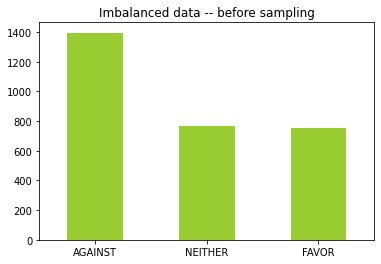

In [101]:
stance_df['Stance'].value_counts().plot(kind='bar', color = 'yellowgreen')
plt.xticks(rotation=0)
plt.title("Imbalanced data -- before sampling")

Performing Over-sampling to balance Data

In [12]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
#print(Counter(y))
oversample = RandomOverSampler(sampling_strategy = 'all')
X_over, y_over = oversample.fit_resample(stance_df[['Tweet', 'Target']], stance_df['Stance'])
print(Counter(y_over))

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


Counter({'AGAINST': 1395, 'FAVOR': 1395, 'NEITHER': 1395})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Balanced data -- after sampling')

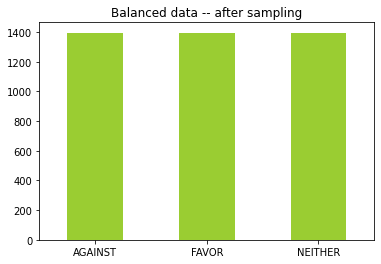

In [13]:
df = pd.DataFrame(X_over, columns = ['Tweet', 'Target'])
df['Stance'] = y_over

df['Stance'].value_counts().plot(kind='bar', color = 'yellowgreen')
plt.xticks(rotation=0)
plt.title("Balanced data -- after sampling")

In [14]:
print("After performing the Random Over sampling, the dataset contains", df.shape[0], 'rows with', df.shape[1], 'variables.')

After performing the Random Over sampling, the dataset contains 4185 rows with 3 variables.


In [102]:
print("Before performing the Random Over sampling, the dataset contains", stance_df.shape[0], 'rows with', stance_df.shape[1], 'variables.')

Before performing the Random Over sampling, the dataset contains 2914 rows with 5 variables.


In [90]:
stance_df.head()

,Tweet,Target,Stance,Opinion Towards,Sentiment
0,"@TEDCRUZ AND, #HANDOVERTHESERVER SHE WIPED CLE...",HILLARY CLINTON,1,1. THE TWEET EXPLICITLY EXPRESSES OPINION ABO...,NEG
1,HILLARY IS OUR BEST CHOICE IF WE TRULY WANT TO...,HILLARY CLINTON,2,1. THE TWEET EXPLICITLY EXPRESSES OPINION ABO...,POS
2,@THEVIEW I THINK OUR COUNTRY IS READY FOR A FE...,HILLARY CLINTON,1,1. THE TWEET EXPLICITLY EXPRESSES OPINION ABO...,NEG
3,I JUST GAVE AN UNHEALTHY AMOUNT OF MY HARD-EAR...,HILLARY CLINTON,1,1. THE TWEET EXPLICITLY EXPRESSES OPINION ABO...,NEG
4,@PORTIAABOULGER THANK YOU FOR ADDING ME TO YOU...,HILLARY CLINTON,0,3. THE TWEET IS NOT EXPLICITLY EXPRESSING OPI...,POS


In [103]:
X = stance_df.drop('Stance',axis=1)

In [104]:
X.shape

(2914, 4)

In [105]:
tweets=X.copy()

##Data Pre-processing

In [106]:
encode = {
    "NEITHER" : 0,
    "AGAINST"  : 1,       
    "FAVOR" : 2,    
}

stance_df['Stance'] = stance_df['Stance'].apply(lambda x: encode[x])
stance_df.head()

,Tweet,Target,Stance,Opinion Towards,Sentiment
0,"@TEDCRUZ AND, #HANDOVERTHESERVER SHE WIPED CLE...",HILLARY CLINTON,1,1. THE TWEET EXPLICITLY EXPRESSES OPINION ABO...,NEG
1,HILLARY IS OUR BEST CHOICE IF WE TRULY WANT TO...,HILLARY CLINTON,2,1. THE TWEET EXPLICITLY EXPRESSES OPINION ABO...,POS
2,@THEVIEW I THINK OUR COUNTRY IS READY FOR A FE...,HILLARY CLINTON,1,1. THE TWEET EXPLICITLY EXPRESSES OPINION ABO...,NEG
3,I JUST GAVE AN UNHEALTHY AMOUNT OF MY HARD-EAR...,HILLARY CLINTON,1,1. THE TWEET EXPLICITLY EXPRESSES OPINION ABO...,NEG
4,@PORTIAABOULGER THANK YOU FOR ADDING ME TO YOU...,HILLARY CLINTON,0,3. THE TWEET IS NOT EXPLICITLY EXPRESSING OPI...,POS


In [107]:
stance_df['Stance'].value_counts()

1    1395
0     766
2     753
Name: Stance, dtype: int64

In [139]:
import re

def process(text):
    """
    Perform the re-processing of tweets.  

    @param text: the text (tweet) to process
    @param tokeniser: tokeniser to use.
    @param stopwords: list of stopwords to use.
      
    @returns: list of (valid) tokens in text
    """
    text = text.lower()
    text = re.sub("["
                                   u"\U0001F600-\U0001F64F"  # emoticons
                                   u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                   u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                   u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                   u"\U00002702-\U000027B0"
                                   u"\U000024C2-\U0001F251"
                                   "]+", '',text)
    
    
    text = re.sub("@", '', text)
    text = re.sub("#", '', text)
    text = re.sub(r'RT[\s]+', '', text) #retweets
    text = re.sub(r'https?:\/\/\S+', '', text)
    text = re.sub('[0-9]+', '', text)
    #tokens = tokeniser.tokenize(text)
    #text  = "".join([char for char in text if char not in stopwords])
    return text

    #return [tok for tok in tokens if tok not in stopwords and not tok.isdigit() and emoji_pattern.match(tok) == None ]

In [140]:
# use built-in nltk tweet tokenizer
import nltk
import string
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from collections import Counter

tweetTokenizer = nltk.tokenize.TweetTokenizer()
punct = list(string.punctuation)
stopwordList = stopwords.words('english') + punct +['.', '...', 'k']

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Tokenization**

In [142]:
corpus = []
for i in range(0, len(tweets)):
    tweet = process(text=tweets['Tweet'][i])
    tokens = tweetTokenizer.tokenize(tweet)
    tok = [tok for tok in tokens if tok not in stopwordList]
    #topic = process(text=tweets['Target'][i], tokeniser=tweetTokenizer, stopwords=stopwordList)
    #topic = ' '.join(topic)
    #tweet = ' '.join(tweet)
    #input = tweet + topic
    corpus.append(tok)

In [143]:
corpus[:2]

[['tedcruz',
  'handovertheserver',
  'wiped',
  'clean',
  'deleted',
  'emails',
  'explains',
  'dereliction',
  'duty',
  'lies',
  'benghazi',
  'etc',
  'tcot'],
 ['hillary',
  'best',
  'choice',
  'truly',
  'want',
  'continue',
  'progressive',
  'nation',
  'ohio']]

**Bi-gram**

In [150]:
import nltk
from nltk.util import ngrams

def extract_ngrams(data, num, stopwords=[]):
    
    #n_grams = ngrams(nltk.word_tokenize(data), num)
    n_grams = ngrams(data, num)
    return [ ' '.join(grams) for grams in n_grams]
 
 

In [151]:
bigram_corpus= []
for i in range(0, len(tweets)):
    tweet = process(text=tweets['Tweet'][i])
    tokenized = tweet.split()
    tokenized = [tok for tok in tokenized if tok not in stopwordList]
    bigram = extract_ngrams(tokenized, 2)
    bigram_corpus.append(bigram)

In [152]:
bigram_corpus[:2]

[['tedcruz and,',
  'and, handovertheserver',
  'handovertheserver wiped',
  'wiped clean',
  'clean deleted',
  'deleted emails,',
  'emails, explains',
  'explains dereliction',
  'dereliction duty/lies',
  'duty/lies benghazi,etc',
  'benghazi,etc tcot'],
 ['hillary best',
  'best choice',
  'choice truly',
  'truly want',
  'want continue',
  'continue progressive',
  'progressive nation.',
  'nation. ohio']]

**Train-test dataset preparation**

In [153]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

validation_split = 0.20
max_length = 25

tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(bigram_corpus)
sequences = tokenizer_obj.texts_to_sequences(bigram_corpus)

word_index = tokenizer_obj.word_index
print("unique tokens - "+str(len(word_index)))
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocab_size - '+str(vocab_size))

lines_pad = pad_sequences(sequences, maxlen=max_length, padding='post')
category =  stance_df['Stance'].values

unique tokens - 26035
vocab_size - 26036


In [154]:
category

array([1, 2, 1, ..., 1, 1, 1])

In [155]:
indices = np.arange(lines_pad.shape[0])
np.random.shuffle(indices)
lines_pad = lines_pad[indices]
category = category[indices]

n_values = np.max(category) + 1
Y = np.eye(n_values)[category]

num_validation_samples = int(validation_split * lines_pad.shape[0])

X_train_pad = lines_pad[:-num_validation_samples]
y_train = Y[:-num_validation_samples]
X_val_pad = lines_pad[-num_validation_samples:]
y_val = Y[-num_validation_samples:]

In [156]:
# Randomly sample some train data
train_len = X_train_pad.shape[0]

idx = np.random.randint(train_len, size=train_len//25)

X_train_pad_sampled = X_train_pad[idx, :]
y_train_sampled = y_train[idx]

In [157]:
print('Shape of X_train_pad:', X_train_pad.shape)
print('Shape of y_train:', y_train.shape)

print('Shape of X_train_pad_sampled:', X_train_pad_sampled.shape)
print('Shape of y_train_sampled:', y_train_sampled.shape)

print('Shape of X_test_pad:', X_val_pad.shape)
print('Shape of y_test:', y_val.shape)

Shape of X_train_pad: (2332, 25)
Shape of y_train: (2332, 3)
Shape of X_train_pad_sampled: (93, 25)
Shape of y_train_sampled: (93, 3)
Shape of X_test_pad: (582, 25)
Shape of y_test: (582, 3)


**Base LSTM Model**

In [158]:
from tensorflow.keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional
from tensorflow.keras.models import Sequential

embedding_dim = 100

embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            input_length=max_length,
                            trainable=True)

model_glove = Sequential()
model_glove.add(embedding_layer)
model_glove.add(LSTM(units=100,  dropout=0.2, recurrent_dropout=0.25))
model_glove.add(Dense(3, activation='softmax'))

model_glove.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

print(model_glove.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 25, 100)           2603600   
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 303       
Total params: 2,684,303
Trainable params: 2,684,303
Non-trainable params: 0
_________________________________________________________________
None


In [159]:
EPOCH = 50

In [160]:
m_histories = {}
m_histories['no_TL' ] = model_glove.fit(X_train_pad_sampled, y_train_sampled, batch_size=32, epochs=EPOCH, validation_data=(X_val_pad, y_val), verbose=1)

Epoch 1/50
3/3 [==============================] - 1s 201ms/step - loss: 1.0896 - categorical_accuracy: 0.4409 - val_loss: 1.0730 - val_categorical_accuracy: 0.4759
Epoch 2/50
3/3 [==============================] - 0s 107ms/step - loss: 1.0774 - categorical_accuracy: 0.4409 - val_loss: 1.0634 - val_categorical_accuracy: 0.4759
Epoch 3/50
3/3 [==============================] - 0s 101ms/step - loss: 1.0727 - categorical_accuracy: 0.4409 - val_loss: 1.0632 - val_categorical_accuracy: 0.4759
Epoch 4/50
3/3 [==============================] - 0s 99ms/step - loss: 1.0707 - categorical_accuracy: 0.4409 - val_loss: 1.0641 - val_categorical_accuracy: 0.4759
Epoch 5/50
3/3 [==============================] - 0s 104ms/step - loss: 1.0681 - categorical_accuracy: 0.4409 - val_loss: 1.0662 - val_categorical_accuracy: 0.4759
Epoch 6/50
3/3 [==============================] - 0s 101ms/step - loss: 1.0665 - categorical_accuracy: 0.4409 - val_loss: 1.0689 - val_categorical_accuracy: 0.4759
Epoch 7/50
3/3 [=